
 K-fold Cross-validation with k = 5
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters (GridSearchCV): {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-validation Accuracy (GridSearchCV): 0.8699999999999999
Test F1-Score (GridSearchCV): 0.879
Test Precision (GridSearchCV): 0.916
Test Recall (GridSearchCV): 0.845
Test Accuracy (GridSearchCV): 0.910
Test RMSE (GridSearchCV): 0.300
Test Log Loss (GridSearchCV): 0.733


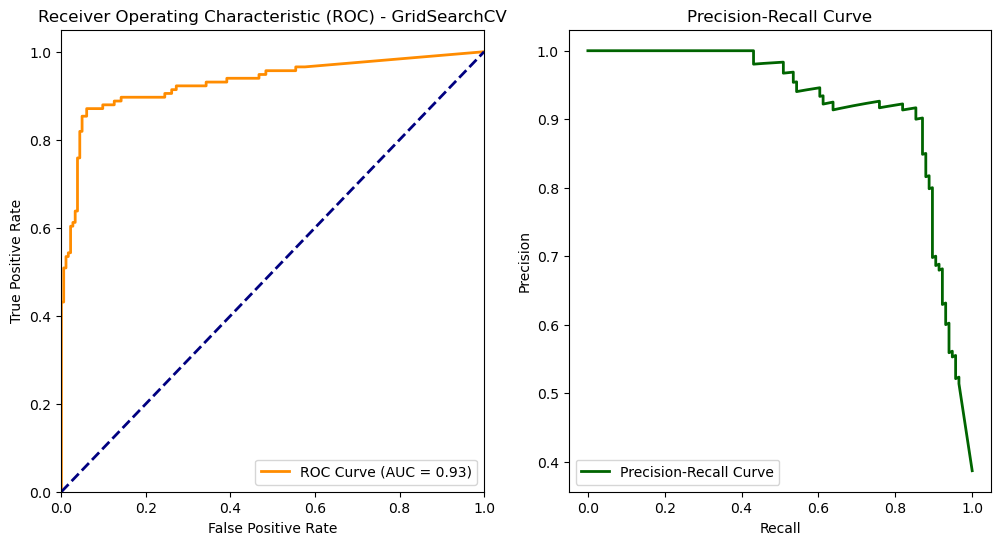

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
Best Cross-validation Accuracy (RandomizedSearchCV): 0.8658333333333333
Test F1-Score (RandomizedSearchCV): 0.879
Test Precision (RandomizedSearchCV): 0.916
Test Recall (RandomizedSearchCV): 0.845
Test Accuracy (RandomizedSearchCV): 0.910
Test RMSE (RandomizedSearchCV): 0.300
Test Log Loss (RandomizedSearchCV): 0.729


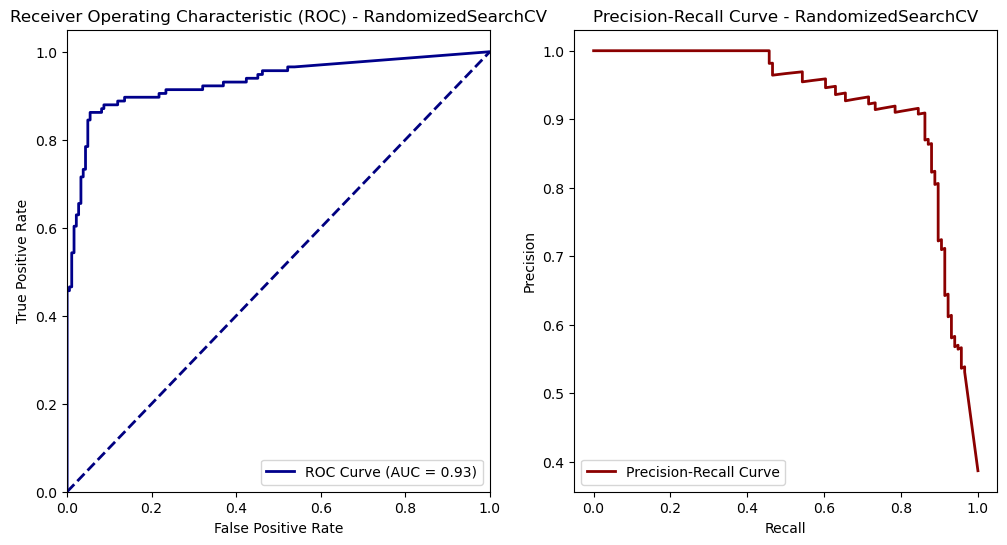


 K-fold Cross-validation with k = 10
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best Hyperparameters (GridSearchCV): {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best Cross-validation Accuracy (GridSearchCV): 0.8775000000000001
Test F1-Score (GridSearchCV): 0.869
Test Precision (GridSearchCV): 0.914
Test Recall (GridSearchCV): 0.828
Test Accuracy (GridSearchCV): 0.903
Test RMSE (GridSearchCV): 0.311
Test Log Loss (GridSearchCV): 0.944


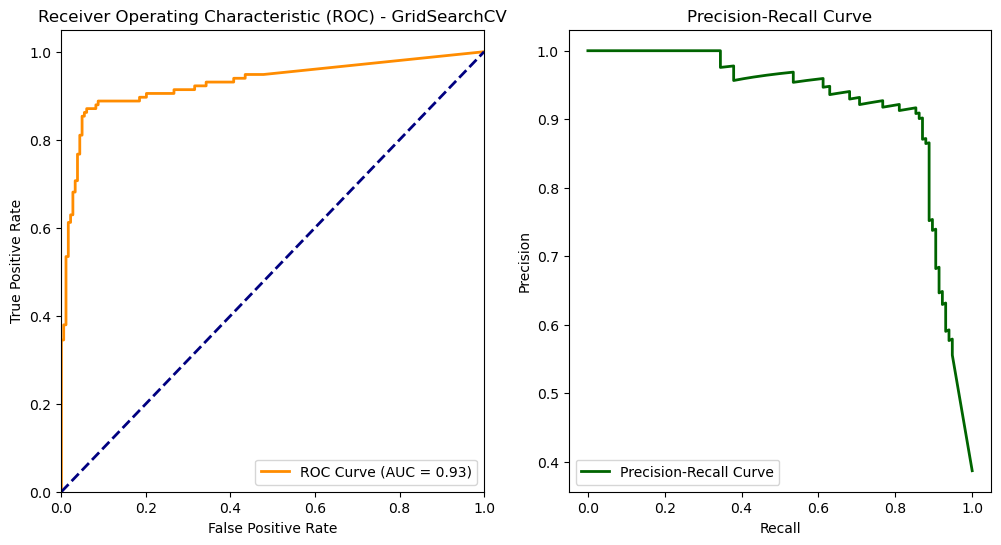

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Hyperparameters (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
Best Cross-validation Accuracy (RandomizedSearchCV): 0.8724999999999999
Test F1-Score (RandomizedSearchCV): 0.877
Test Precision (RandomizedSearchCV): 0.893
Test Recall (RandomizedSearchCV): 0.862
Test Accuracy (RandomizedSearchCV): 0.907
Test RMSE (RandomizedSearchCV): 0.306
Test Log Loss (RandomizedSearchCV): 1.603


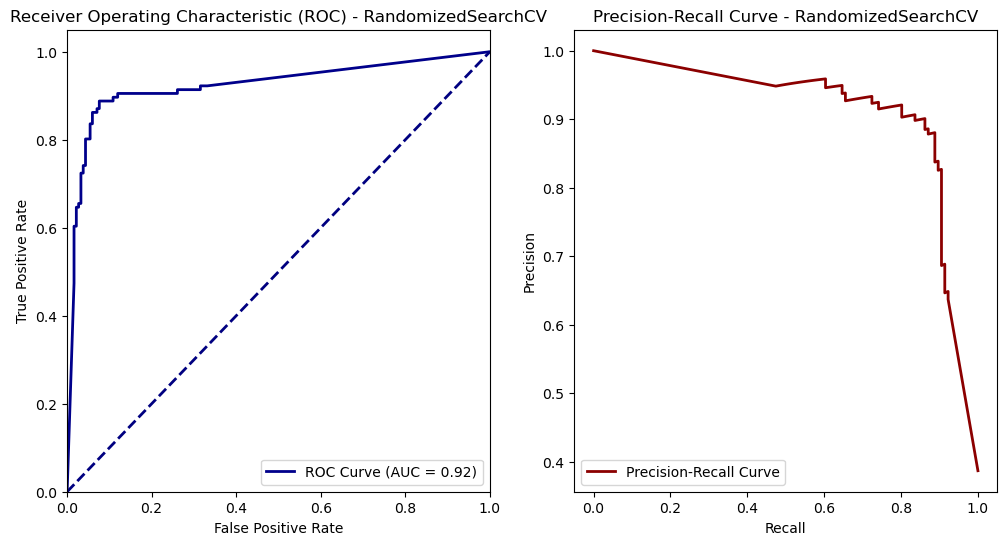

['../Models/best_model/kmeans.pkl']

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, log_loss, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data
df = pd.read_csv("../data/The_Cancer_data_1500_V2.csv")

# Split data into features and target
X = df.iloc[:, :8]  # Features (first 8 columns)
y = df.iloc[:, 8]   # Target (9th column)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform KMeans clustering on the training data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)

# Generate cluster labels for the training and test sets
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

# Append the cluster labels to the scaled features
X_train_with_clusters = np.hstack([X_train_scaled, train_clusters.reshape(-1, 1)])
X_test_with_clusters = np.hstack([X_test_scaled, test_clusters.reshape(-1, 1)])

# Set up parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
}

knn = KNeighborsClassifier()

# K-Fold Cross-validation for GridSearchCV
for k in [5, 10]:
    print(f"\n K-fold Cross-validation with k = {k}")

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                               cv=kf, scoring='accuracy',
                               verbose=1, n_jobs=-1)

    grid_search.fit(X_train_with_clusters, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Hyperparameters (GridSearchCV):", best_params)
    print("Best Cross-validation Accuracy (GridSearchCV):", best_score)

    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_with_clusters)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust for multiclass as needed
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    mse = np.sqrt(((y_test - y_pred) ** 2).mean())  # RMSE
    y_pred_proba = best_knn.predict_proba(X_test_with_clusters)
    nll = log_loss(y_test, y_pred_proba)

    print(f"Test F1-Score (GridSearchCV): {f1:.3f}")
    print(f"Test Precision (GridSearchCV): {precision:.3f}")
    print(f"Test Recall (GridSearchCV): {recall:.3f}")
    print(f"Test Accuracy (GridSearchCV): {accuracy:.3f}")
    print(f"Test RMSE (GridSearchCV): {mse:.3f}")
    print(f"Test Log Loss (GridSearchCV): {nll:.3f}")

    # ROC Curve
    y_pred_proba = best_knn.predict_proba(X_test_with_clusters)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

    # Plot ROC Curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) - GridSearchCV")
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f"Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.show()

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
                                       n_iter=10, cv=kf, scoring='accuracy',  # 10 random samples
                                       verbose=1, n_jobs=-1, random_state=42)

    random_search.fit(X_train_with_clusters, y_train)

    best_params_random = random_search.best_params_
    best_score_random = random_search.best_score_

    print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)
    print("Best Cross-validation Accuracy (RandomizedSearchCV):", best_score_random)

    best_knn_random = random_search.best_estimator_
    y_pred_random = best_knn_random.predict(X_test_with_clusters)

    # Calculate metrics
    f1_random = f1_score(y_test, y_pred_random, average='binary')
    precision_random = precision_score(y_test, y_pred_random, average='binary')
    recall_random = recall_score(y_test, y_pred_random, average='binary')
    accuracy_random = accuracy_score(y_test, y_pred_random)
    mse_random = np.sqrt(((y_test - y_pred_random) ** 2).mean())  # RMSE
    y_pred_proba_random = best_knn_random.predict_proba(X_test_with_clusters)
    nll_random = log_loss(y_test, y_pred_proba_random)

    print(f"Test F1-Score (RandomizedSearchCV): {f1_random:.3f}")
    print(f"Test Precision (RandomizedSearchCV): {precision_random:.3f}")
    print(f"Test Recall (RandomizedSearchCV): {recall_random:.3f}")
    print(f"Test Accuracy (RandomizedSearchCV): {accuracy_random:.3f}")
    print(f"Test RMSE (RandomizedSearchCV): {mse_random:.3f}")
    print(f"Test Log Loss (RandomizedSearchCV): {nll_random:.3f}")

    # ROC Curve for RandomizedSearchCV
    y_pred_proba_random = best_knn_random.predict_proba(X_test_with_clusters)[:, 1]
    fpr_random, tpr_random, thresholds_random = roc_curve(y_test, y_pred_proba_random)
    roc_auc_random = auc(fpr_random, tpr_random)

    # Precision-Recall Curve for RandomizedSearchCV
    precision_vals_random, recall_vals_random, _ = precision_recall_curve(y_test, y_pred_proba_random)

    # Plot ROC Curve for RandomizedSearchCV
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_random, tpr_random, color='darkblue', lw=2, label=f"ROC Curve (AUC = {roc_auc_random:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) - RandomizedSearchCV")
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve for RandomizedSearchCV
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals_random, precision_vals_random, color='darkred', lw=2, label=f"Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - RandomizedSearchCV")
    plt.legend(loc="lower left")

    plt.show()
    
import joblib
joblib.dump(best_knn, "../Models/best_model/best_knn_gridsearch.pkl")
joblib.dump(best_knn_random, "../Models/best_model/best_knn_randomsearch.pkl")

# Save the scaler
joblib.dump(scaler, "../Models/best_model/scaler.pkl")

# Save the KMeans clustering model
joblib.dump(kmeans, "../Models/best_model/kmeans.pkl")



## Below are for testing purpose 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, log_loss, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data
df = pd.read_csv("../data/The_Cancer_data_1500_V2.csv")

# Split data into features and target
X = df.iloc[:, :8]  # Features (first 8 columns)
y = df.iloc[:, 8]   # Target (9th column)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform KMeans clustering on the training data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)

# Generate cluster labels for the training and test sets
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

# Append the cluster labels to the scaled features
X_train_with_clusters = np.hstack([X_train_scaled, train_clusters.reshape(-1, 1)])
X_test_with_clusters = np.hstack([X_test_scaled, test_clusters.reshape(-1, 1)])

# Set up parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function for neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
}

knn = KNeighborsClassifier()

# K-Fold Cross-validation for GridSearchCV
for k in [5, 10]:
    print(f"\n K-fold Cross-validation with k = {k}")

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                               cv=kf, scoring='accuracy',
                               verbose=1, n_jobs=-1)

    grid_search.fit(X_train_with_clusters, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Hyperparameters (GridSearchCV):", best_params)
    print("Best Cross-validation Accuracy (GridSearchCV):", best_score)

    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_with_clusters)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust for multiclass as needed
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    mse = np.sqrt(((y_test - y_pred) ** 2).mean())  # RMSE
    y_pred_proba = best_knn.predict_proba(X_test_with_clusters)
    nll = log_loss(y_test, y_pred_proba)

    print(f"Test F1-Score (GridSearchCV): {f1:.3f}")
    print(f"Test Precision (GridSearchCV): {precision:.3f}")
    print(f"Test Recall (GridSearchCV): {recall:.3f}")
    print(f"Test Accuracy (GridSearchCV): {accuracy:.3f}")
    print(f"Test RMSE (GridSearchCV): {mse:.3f}")
    print(f"Test Log Loss (GridSearchCV): {nll:.3f}")

    # ROC Curve
    y_pred_proba = best_knn.predict_proba(X_test_with_clusters)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

    # Plot ROC Curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) - GridSearchCV")
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f"Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.show()

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
                                       n_iter=10, cv=kf, scoring='accuracy',  # 10 random samples
                                       verbose=1, n_jobs=-1, random_state=42)

    random_search.fit(X_train_with_clusters, y_train)

    best_params_random = random_search.best_params_
    best_score_random = random_search.best_score_

    print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)
    print("Best Cross-validation Accuracy (RandomizedSearchCV):", best_score_random)

    best_knn_random = random_search.best_estimator_
    y_pred_random = best_knn_random.predict(X_test_with_clusters)

    # Calculate metrics
    f1_random = f1_score(y_test, y_pred_random, average='binary')
    precision_random = precision_score(y_test, y_pred_random, average='binary')
    recall_random = recall_score(y_test, y_pred_random, average='binary')
    accuracy_random = accuracy_score(y_test, y_pred_random)
    mse_random = np.sqrt(((y_test - y_pred_random) ** 2).mean())  # RMSE
    y_pred_proba_random = best_knn_random.predict_proba(X_test_with_clusters)
    nll_random = log_loss(y_test, y_pred_proba_random)

    print(f"Test F1-Score (RandomizedSearchCV): {f1_random:.3f}")
    print(f"Test Precision (RandomizedSearchCV): {precision_random:.3f}")
    print(f"Test Recall (RandomizedSearchCV): {recall_random:.3f}")
    print(f"Test Accuracy (RandomizedSearchCV): {accuracy_random:.3f}")
    print(f"Test RMSE (RandomizedSearchCV): {mse_random:.3f}")
    print(f"Test Log Loss (RandomizedSearchCV): {nll_random:.3f}")

    # ROC Curve for RandomizedSearchCV
    y_pred_proba_random = best_knn_random.predict_proba(X_test_with_clusters)[:, 1]
    fpr_random, tpr_random, thresholds_random = roc_curve(y_test, y_pred_proba_random)
    roc_auc_random = auc(fpr_random, tpr_random)

    # Precision-Recall Curve for RandomizedSearchCV
    precision_vals_random, recall_vals_random, _ = precision_recall_curve(y_test, y_pred_proba_random)

    # Plot ROC Curve for RandomizedSearchCV
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_random, tpr_random, color='darkblue', lw=2, label=f"ROC Curve (AUC = {roc_auc_random:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) - RandomizedSearchCV")
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve for RandomizedSearchCV
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals_random, precision_vals_random, color='darkred', lw=2, label=f"Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - RandomizedSearchCV")
    plt.legend(loc="lower left")
    plt.show()